# Ciência dos Dados
## Projeto 2 - Walmart
### Integrantes do Grupo:

* Antônio Amaral Egydio Martins
* Arthur Martins de Souza Barreto

### Professor Orientador:
* Maria Kelly Venezuela

### Proposta Norteadora:

Buscamos entender como o meio interno e externo impactam diretamente na quantidade de itens vendidos no WalMart nos Estados Unidos entre 5/2/2010 até 1/11/2012. Sendo assim para este trabalho utilizaremos como Feature interna o ID da loja - que pode impactas nas vendas por existirem diferentes lojas em diferentes locais… - e como Features Externas os índices CPI (Prevailing consumer price index), Fuel Price, Unemployment e Temperature que afetam diretamente o bem estar e poder aquisitivo do consumidor - podendo aumentar ou reduzir seu consumo semanal.

### Introdução
#### `Importando bibliocas utilizadas:`

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import os

#### `Importando base de dados`

In [36]:
#Checando Diretório 
print("Esperamos trabalhar no diretório")
print(os.getcwd())

Esperamos trabalhar no diretório
/Users/antonioamaralegydiomartins/Desktop/Antônio/GitHub - Pessoal/INSPER/Formula1_predicting_lap_time


In [37]:
df = pd.read_csv('Walmart_Store_sales.csv')
df.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


#### `Checando o  DataFrame`

**Dicionário de dados:**


Variável | Descrição
:---:|---:
Store | ID de Reconhecimento das Lojas
Weekly_Sales | Vendas Semanais
Holiday_Flag | Variavel Booleana para Feriados 
Temperature | Temperatura Exterior as lojas (Fahrenheit)
Fuel_Price | Preço do Galão de Combustivel (USD)
Prevailing consumer price index | Unidade utilizada para medir inflação
Unemployment | Taxa de Desemprego (%)


A variável *Holiday_Flag* identifica se é feriado ou não.

Valor | Significado
:---:|:---:
0 | É Feriado
1 | Não é Feriado

#### Vamos analizar as variaveis quantitativas

In [38]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


Verificando valores nulos:

In [39]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

#### Impressões inciais
O dataframe está ok para a analize exploratória. 

### Analize exploratória

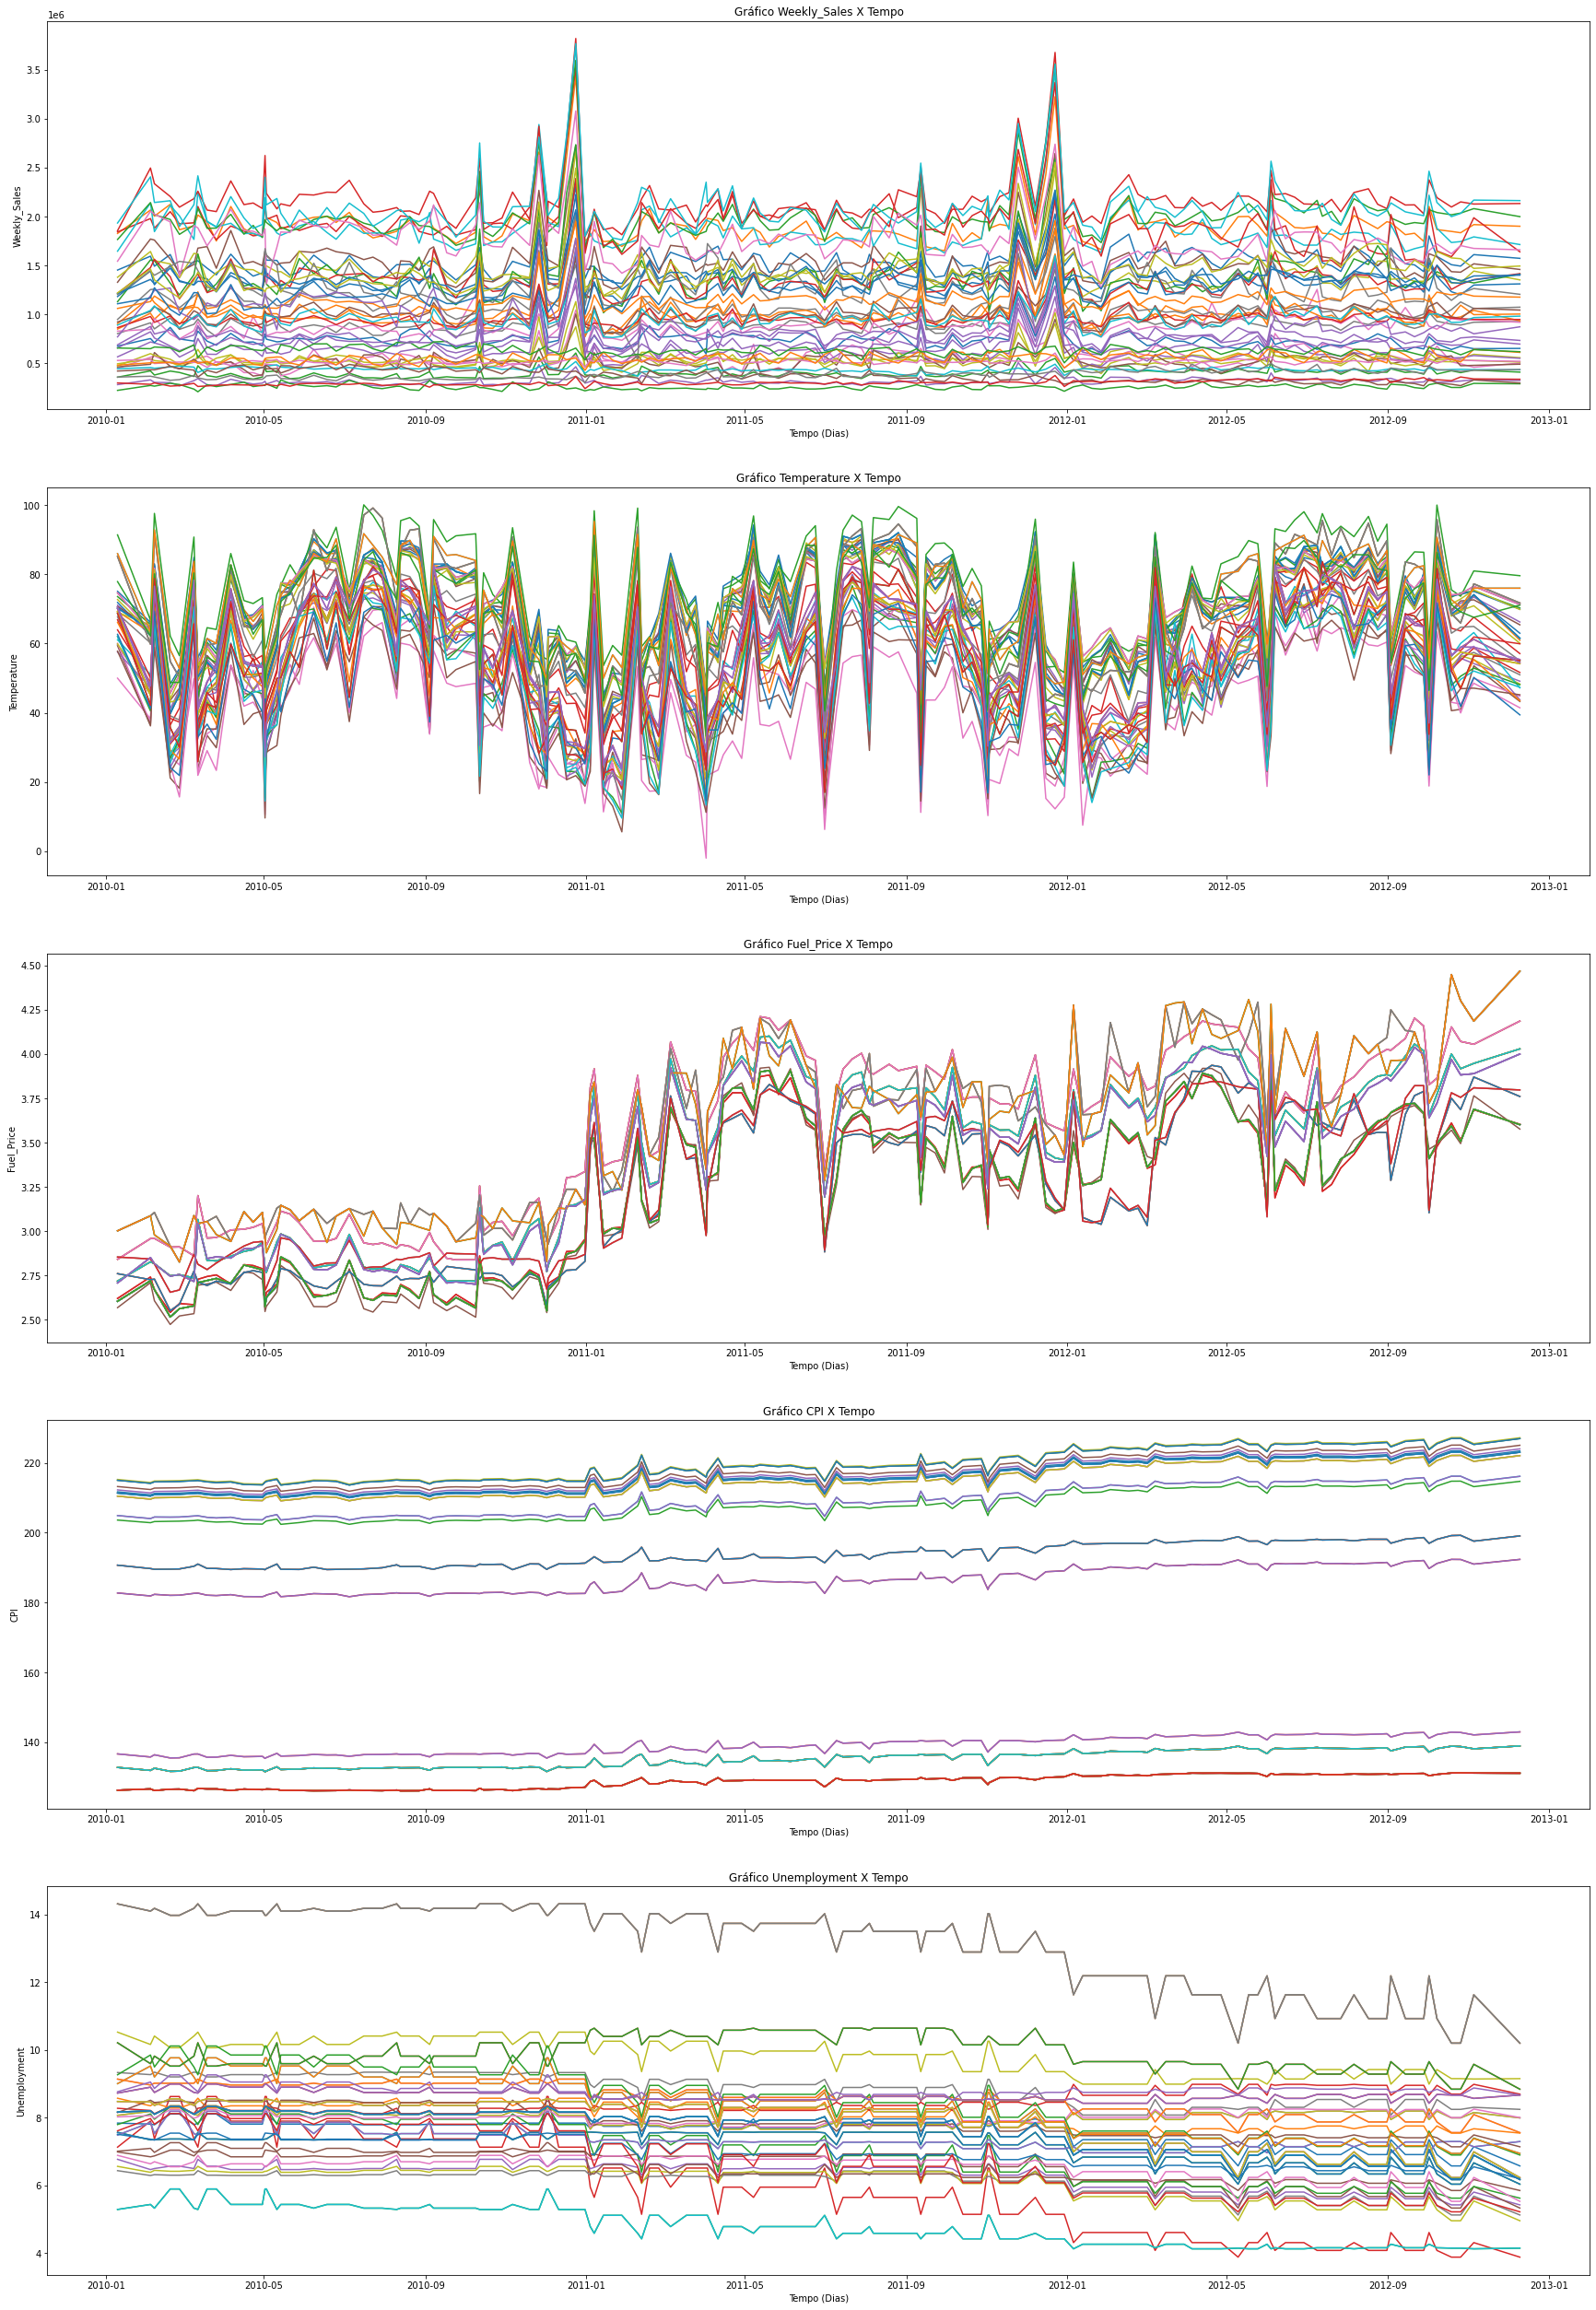

In [40]:
df.Date = pd.to_datetime(df.Date)
df_ordenado = df.sort_values(by='Date')
l_variaveis = ["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment"]
l_subplots = [511,512,513,514,515]
plt.figure(figsize = (30,45))

index = 0
for variavel in l_variaveis:
    plt.subplot(l_subplots[index])
    for loja in range(1,46):
        dados_loja = df_ordenado.loc[df['Store'] == loja]
        plt.plot(dados_loja.Date, dados_loja[variavel])
        plt.title(f"Gráfico {variavel} X Tempo")
        plt.ylabel(variavel)
        plt.xlabel("Tempo (Dias)")
    index += 1
plt.show()